In [1]:
import pandas as pd
from prophet import Prophet

/jupyter/notebooks/.venvs/tensor_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Data/Miles_Traveled.csv')

In [3]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


* The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
df.columns = ['ds', 'y']

In [6]:
df['ds'] = pd.to_datetime(df['ds'])

In [7]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


<Axes: xlabel='ds'>

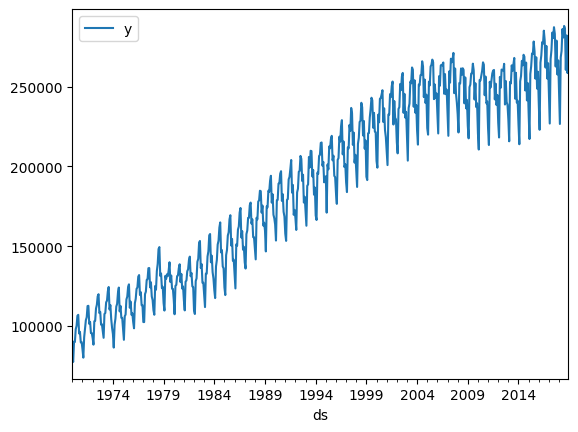

In [8]:
df.plot(x='ds', y='y')

In [9]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [10]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

13:54:03 - cmdstanpy - INFO - Chain [1] start processing


13:54:04 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263314.104520,273715.933837,285519.521456,263241.293331,263357.353131,16448.461005,16448.461005,16448.461005,16448.461005,16448.461005,16448.461005,0.0,0.0,0.0,279762.565525
584,2018-09-01,263454.115447,256226.263998,267258.296254,263354.357303,263531.974191,-1667.702695,-1667.702695,-1667.702695,-1667.702695,-1667.702695,-1667.702695,0.0,0.0,0.0,261786.412752
585,2018-10-01,263589.609893,263559.450430,274388.254155,263456.213031,263693.070354,5310.650005,5310.650005,5310.650005,5310.650005,5310.650005,5310.650005,0.0,0.0,0.0,268900.259898
586,2018-11-01,263729.620821,249729.044266,261469.243155,263558.040835,263870.863121,-8205.691591,-8205.691591,-8205.691591,-8205.691591,-8205.691591,-8205.691591,0.0,0.0,0.0,255523.929230
587,2018-12-01,263865.115267,250630.899224,263138.991205,263644.747718,264034.896581,-6916.814105,-6916.814105,-6916.814105,-6916.814105,-6916.814105,-6916.814105,0.0,0.0,0.0,256948.301162


<Axes: xlabel='ds'>

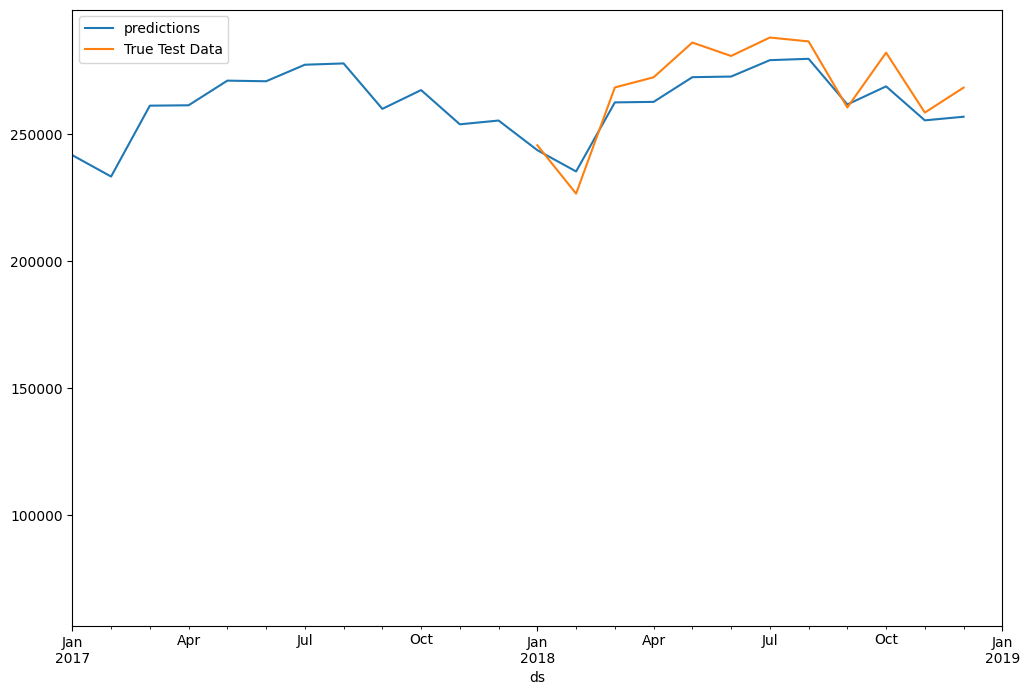

In [12]:
ax = forecast.plot(x='ds', y='yhat', label='predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2017-01-01', '2019-01-01')) # type: ignore

In [13]:
from statsmodels.tools.eval_measures import rmse

In [14]:
predictions = forecast.iloc[-12:]['yhat']
predictions

576    243770.822686
577    235394.261463
578    262595.403685
579    262797.383159
580    272522.812187
581    272768.932420
582    279228.884146
583    279762.565525
584    261786.412752
585    268900.259898
586    255523.929230
587    256948.301162
Name: yhat, dtype: float64

In [15]:
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [16]:
rmse(predictions, test['y'])

8683.826600295057

In [17]:
test['y'].mean()

268739.6666666667

### Cross validation
* lets cross validate by taking period of 5 years as training, then validate on next year
* then move the training by one year and validate on next next year and so on

In [18]:
from prophet.diagnostics import cross_validation, performance_metrics # type:ignore
from prophet.plot import plot_cross_validation_metric # type:ignore

In [19]:
# pd.Timedelta shows how to break apart time information
pd.Timedelta

pandas._libs.tslibs.timedeltas.Timedelta

In [20]:
# INITIAL
initial = 5*365 # period of 5 years
initial = str(initial) + ' days'

In [21]:
# PERIOD - how many times to fold
period = 5*365 # fold every 5 years
period = str(period) + ' days'


In [22]:
# HORIZON
# how far to forecast in each period
horizon = 365
horizon = str(horizon) + ' days'

In [23]:
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

  0%|          | 0/9 [00:00<?, ?it/s]13:54:04 - cmdstanpy - INFO - Chain [1] start processing


13:54:05 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:05,  1.46it/s]13:54:05 - cmdstanpy - INFO - Chain [1] start processing
13:54:05 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:02,  2.53it/s]13:54:05 - cmdstanpy - INFO - Chain [1] start processing
13:54:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:01<00:01,  3.31it/s]13:54:06 - cmdstanpy - INFO - Chain [1] start processing
13:54:06 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:01<00:01,  3.83it/s]13:54:06 - cmdstanpy - INFO - Chain [1] start processing
13:54:06 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:01<00:01,  3.92it/s]13:54:06 - cmdstanpy - INFO - Chain [1] start processing
13:54:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:01<00:00,  4.00it/s]13:54:06 - cmdstanpy - INFO - Chain [1] start processing
13:54:06 - cmdstanpy - INFO - Chain [1] done process

In [24]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.057858,106991.650762,109884.757177,102445.0,1976-12-11
1,1977-02-01,102996.081778,101626.783906,104405.978642,102416.0,1976-12-11
2,1977-03-01,118973.288994,117583.273803,120415.224405,119960.0,1976-12-11
3,1977-04-01,120612.898024,119190.111981,122155.479713,121513.0,1976-12-11
4,1977-05-01,127882.998527,126393.901041,129386.691017,128884.0,1976-12-11


In [25]:
len(df_cv)

108

In [26]:
len(train)/len(df_cv)

5.333333333333333

In [27]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,52 days,2.412432e+07,4911.651417,4515.534952,0.027638,0.023395,0.027222,0.3
1,53 days,2.156612e+07,4643.933934,4241.186631,0.024808,0.023395,0.024515,0.3
2,54 days,1.821484e+07,4267.884332,3721.752145,0.019965,0.022523,0.019808,0.4
3,55 days,2.305683e+07,4801.752580,4241.764270,0.023025,0.023395,0.022778,0.3
4,57 days,2.092495e+07,4574.380184,3982.697965,0.021331,0.022523,0.021123,0.4
...,...,...,...,...,...,...,...,...
94,360 days,1.828466e+07,4276.056200,3760.860092,0.019642,0.019520,0.019653,0.5
95,361 days,1.741032e+07,4172.567923,3486.840112,0.018273,0.018900,0.018295,0.5
96,362 days,3.167534e+07,5628.085002,4411.288478,0.022067,0.024394,0.021969,0.4
97,364 days,3.004782e+07,5481.588752,4260.656360,0.021510,0.021933,0.021424,0.5


In [28]:
len(train)


576

initial = 5 years -> 1825 days <br>
period = 5 years -> 1825 days <br>
horizon = 1 year -> 365 days <br>

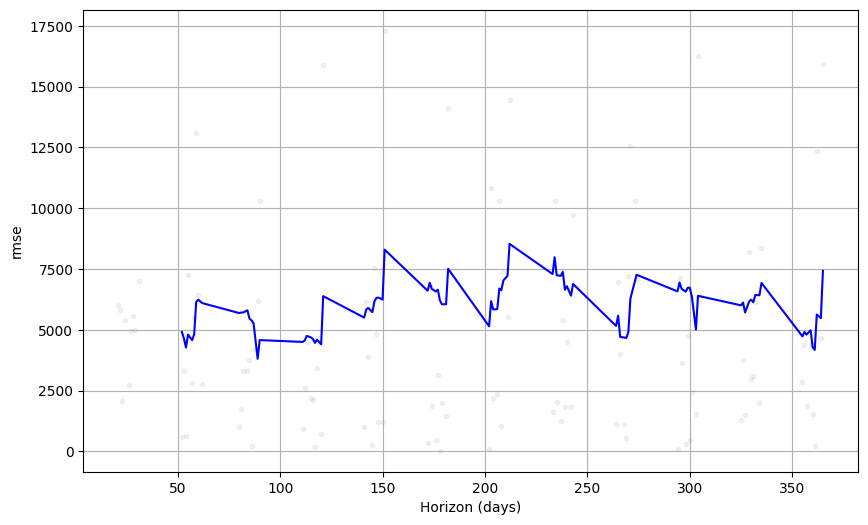

In [29]:
plot_cross_validation_metric(df_cv, metric='rmse');

### find the trend

In [30]:
from prophet.plot import add_changepoints_to_plot

In [32]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263314.104520,273715.933837,285519.521456,263241.293331,263357.353131,16448.461005,16448.461005,16448.461005,16448.461005,16448.461005,16448.461005,0.0,0.0,0.0,279762.565525
584,2018-09-01,263454.115447,256226.263998,267258.296254,263354.357303,263531.974191,-1667.702695,-1667.702695,-1667.702695,-1667.702695,-1667.702695,-1667.702695,0.0,0.0,0.0,261786.412752
585,2018-10-01,263589.609893,263559.450430,274388.254155,263456.213031,263693.070354,5310.650005,5310.650005,5310.650005,5310.650005,5310.650005,5310.650005,0.0,0.0,0.0,268900.259898
586,2018-11-01,263729.620821,249729.044266,261469.243155,263558.040835,263870.863121,-8205.691591,-8205.691591,-8205.691591,-8205.691591,-8205.691591,-8205.691591,0.0,0.0,0.0,255523.929230
587,2018-12-01,263865.115267,250630.899224,263138.991205,263644.747718,264034.896581,-6916.814105,-6916.814105,-6916.814105,-6916.814105,-6916.814105,-6916.814105,0.0,0.0,0.0,256948.301162


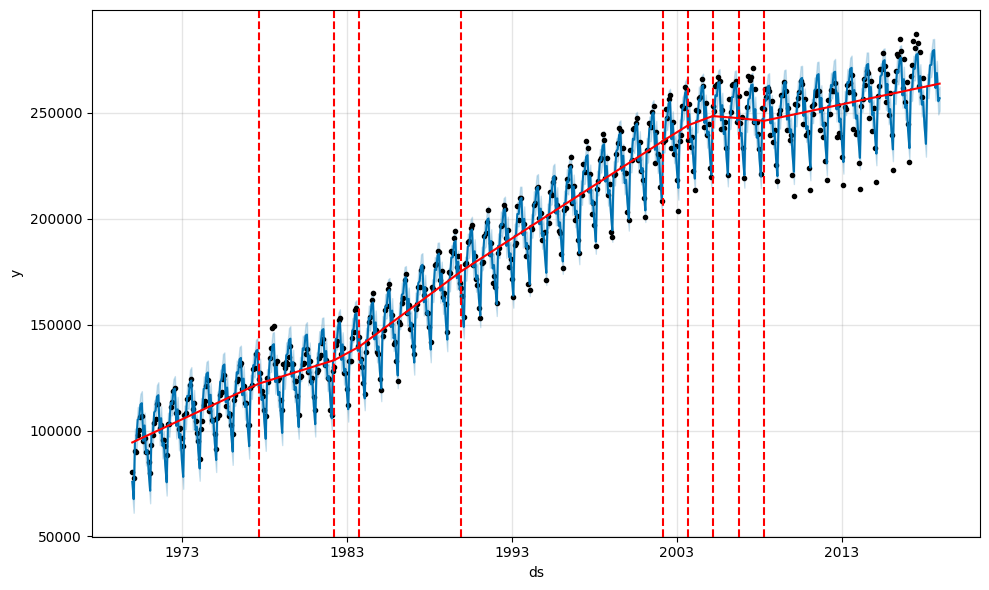

In [33]:
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

#### Seasonality

In [34]:
df = pd.read_csv('Data/airline_passengers.csv')

In [35]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

14:02:31 - cmdstanpy - INFO - Chain [1] start processing
14:02:31 - cmdstanpy - INFO - Chain [1] done processing


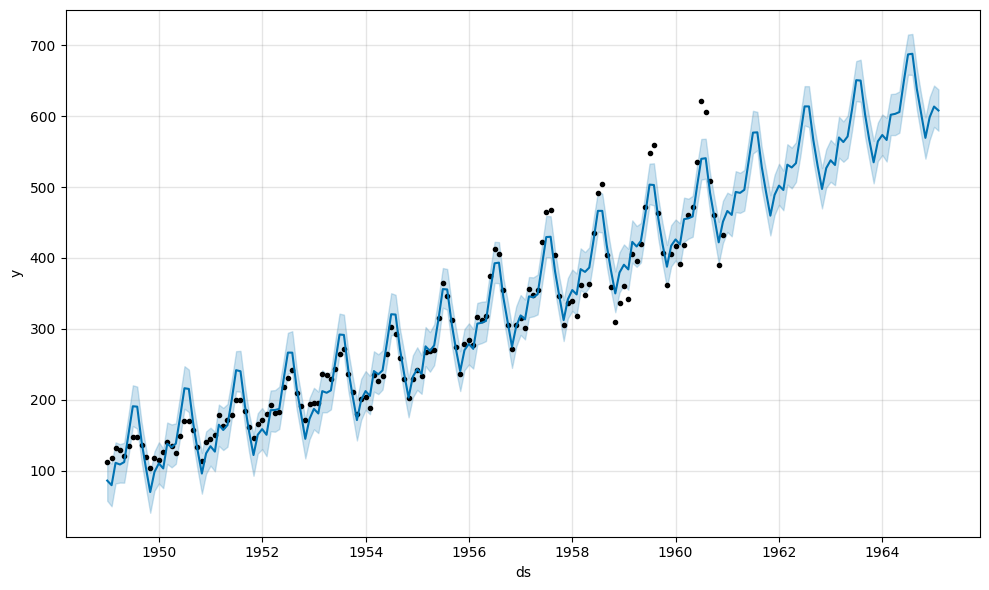

In [38]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

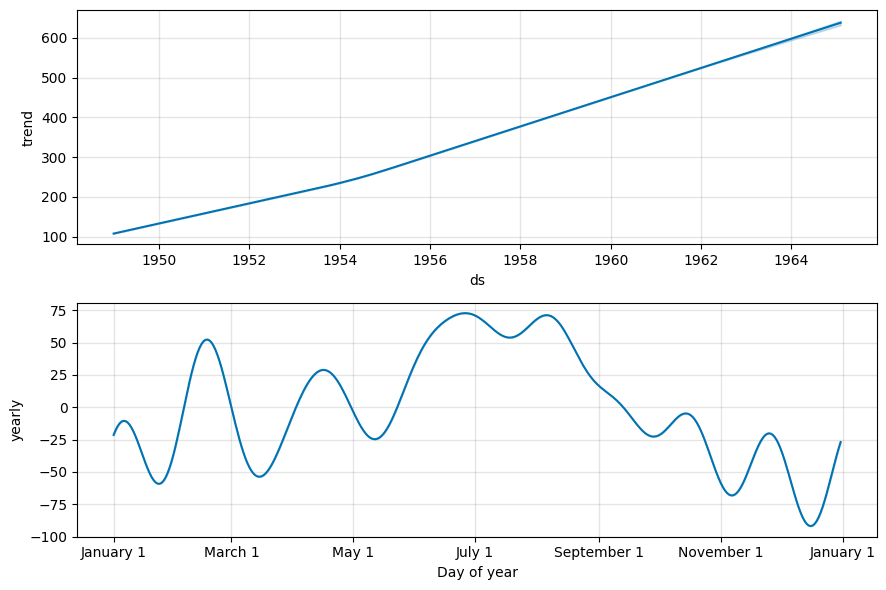

In [42]:
fig = m.plot_components(forecast)

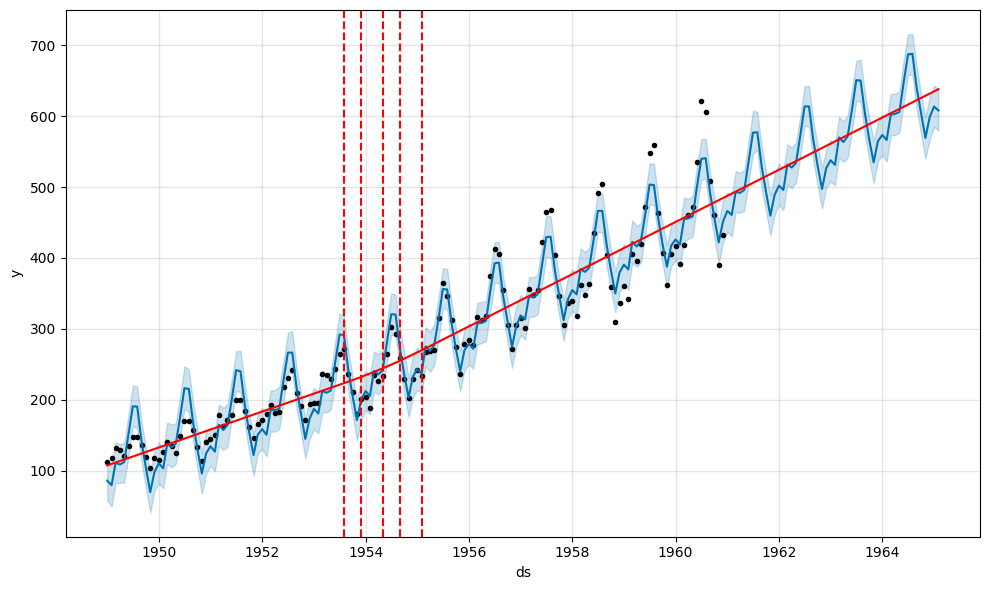

In [43]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

#### Redo the model with multiplicative type

14:07:08 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing


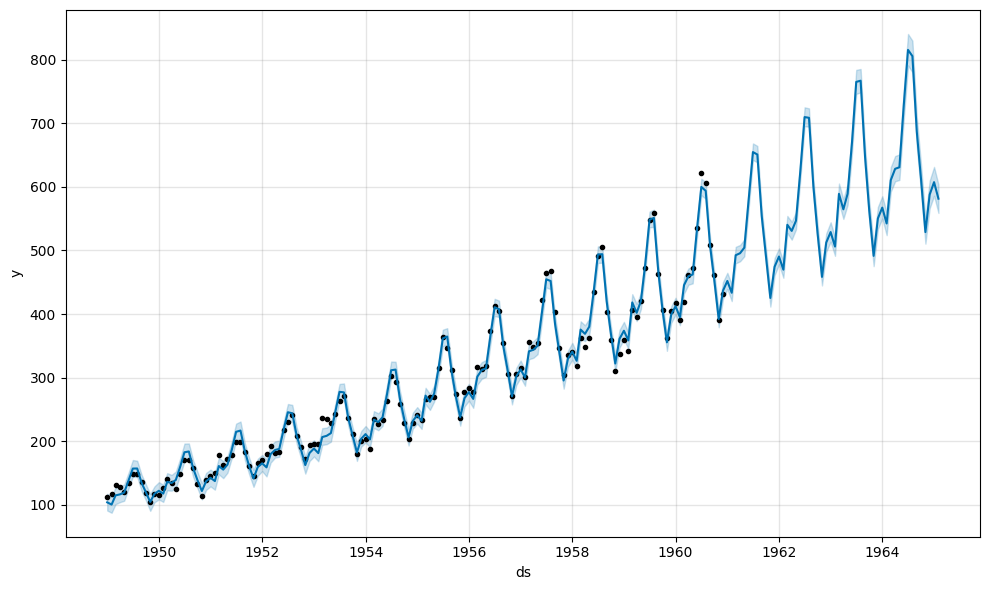

In [44]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

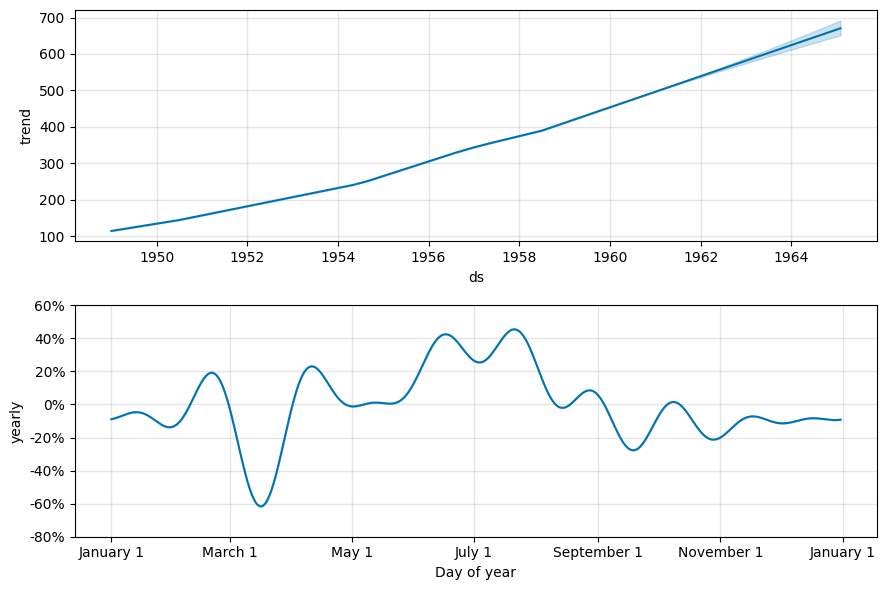

In [46]:
m.plot_components(forecast);